# Clustering

En este tutorial aprenderemos a trabajar t√©cnicas de clustering. En el tutorial veremos distintos modelos:
- Basados en particiones: K-Medias, K-medoids.
- M√©todos jer√°rquicos.
- Basados en densidad: DBSCAN



# Kmeans

En este ejemplo, vamos a generar un conjunto de muestras aleatorias. Comenzamos a generar estos datos

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gr√°ficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuraci√≥n warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

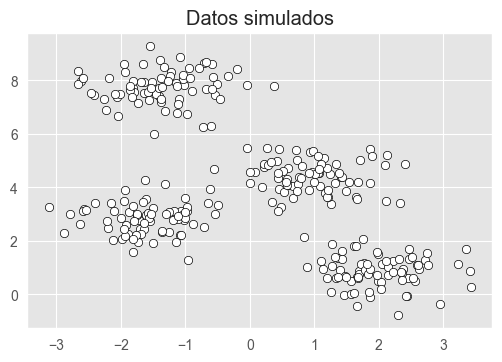

In [2]:
# Simulaci√≥n de datos
# ==============================================================================
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados');

La implementaci√≥n de `sklearn.cluster.KMeans` tiene los siguientes par√°metros:
- `n_clusters`: determina el n√∫mero *ùêæ* de clusters que se van a generar.
- `init`: estrategia para asignar los centroides iniciales. Por defecto se emplea 'k-means++', una estrategia que trata de alejar los centroides lo m√°ximo posible facilitando la convergencia. Sin embargo, esta estrategia puede ralentizar el proceso cuando hay muchos datos, si esto ocurre, es mejor utilizar 'random'.
- `n_init`: determina el n√∫mero de veces que se va a repetir el proceso, cada vez con una asignaci√≥n aleatoria inicial distinta. Es recomendable que este √∫ltimo valor sea alto, entre 10-25, para no obtener resultados sub√≥ptimos debido a una iniciaci√≥n poco afortunada del proceso.
- `max_iter`: n√∫mero m√°ximo de iteraciones permitidas.
- `random_state`: semilla para garantizar la reproducibilidad de los resultados.

In [3]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(X)

In [4]:
# Modelo
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=42)

El objeto devuelto por `KMeans()` contiene entre otros datos: la media de cada una de las variables para cada cluster (`cluster_centers_`), es decir, los centroides. Un vector indicando a qu√© cluster se ha asignado cada observaci√≥n (`.labels_`) y la suma total de cuadrados internos de todos los clusters (`.inertia_`).

Vamos a pintar como nos quedan los clusters

In [5]:
# Clasificaci√≥n con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

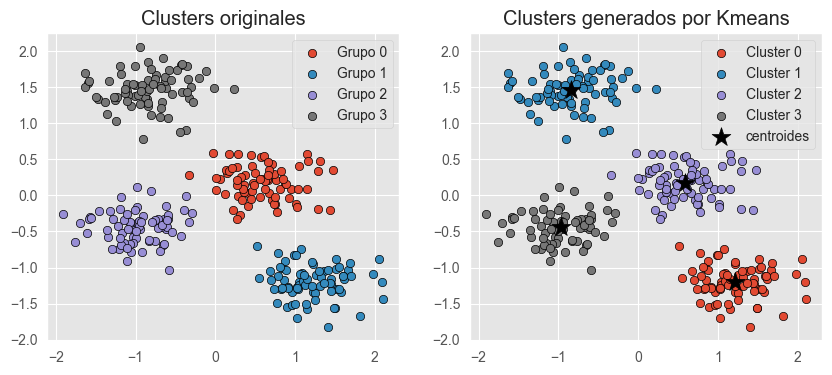

In [6]:
# Representaci√≥n gr√°fica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

Podemos ver tambi√©n el n√∫mero de aciertos y errores. Podemos verlo como una matriz de confusi√≥n. Aqu√≠ hay que tener cuidado que Kmeans asigna un cluster cuyo n√∫mero puede ser distinto. Por lo tanto, cada fila tiene que tener un n√∫mero alto (aciertos) y en las dem√°s posiciones valores bajos (errores de clasificaci√≥n)

In [7]:
# Matriz de confusi√≥n: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

cluster      0   1   2   3
grupo_real                
0            0   0  75   0
1           75   0   0   0
2            0   0   0  75
3            0  75   0   0

Vamos a ver que pasar√≠a si en vez de decirle a KMeans que son 4 clusters, le decimos que K=2 √≥ K=6

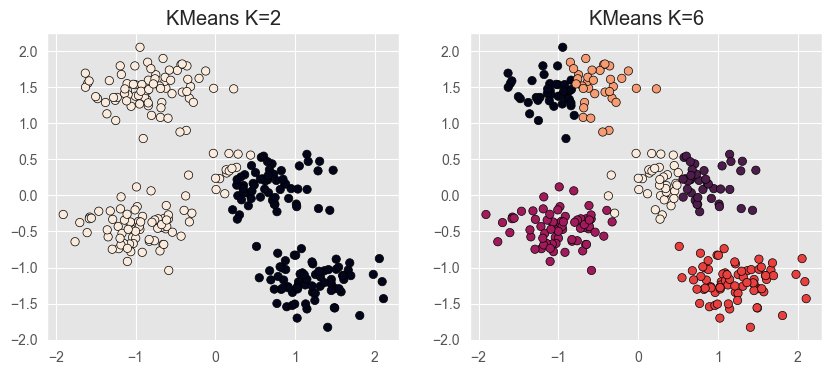

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ==============================================================================
y_predict = KMeans(n_clusters=2, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[0].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[0].set_title('KMeans K=2');

# Resultados para K = 6
# ==============================================================================
y_predict = KMeans(n_clusters=6, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[1].scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = y_predict,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[1].set_title('KMeans K=6');

## N√∫mero de clusters

### M√©todo del codo (Elbow method)
La soluci√≥n al problema anterior es hacer una b√∫squeda de cual ser√≠a el K mejor. La idea es obtener para valor de K la suma de los cuadrados de la distancia de cada punto con el centroide al que se encuentra asignado (se obtiene de `.inertia_`). Es una medida de lo coherentes que son internamente los clusters. La idea es que si K crece el valor de `.inertia_` es menor porque cada cluster es m√°s peque√±o. Sin embargo, a partir de cierto punto, la adici√≥n de m√°s clusters proporciona rendimientos decrecientes en t√©rminos de reducci√≥n de `.inertia_`, y la tasa de disminuci√≥n se ralentiza, formando un codo en el gr√°fico. Ese ser√≠a el valor √≥ptimo para seleccionar.

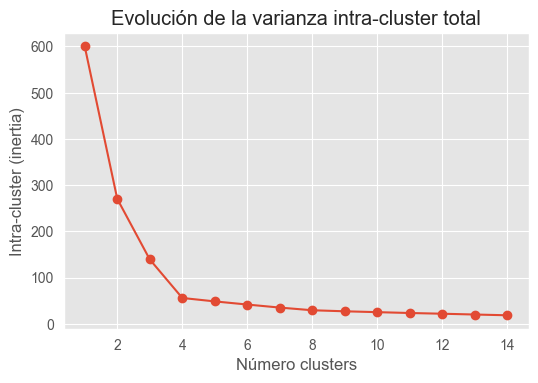

In [9]:
# M√©todo elbow para identificar el n√∫mero √≥ptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evoluci√≥n de la varianza intra-cluster total")
ax.set_xlabel('N√∫mero clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Vemos como el valor √≥ptimo es K=4, como ya sab√≠amos.

### M√©todo Silhouette
Algunas veces, con el m√©todo Elbow es dif√≠cil determinar en n√∫mero √≥ptimo de clusters. Otra aproximaci√≥n es el m√©todo Silhouette. Utiliza la distancia media intracl√∫ster y la distancia media cl√∫ster m√°s cercano para cada muestra. Cuanto mayor sea el valor de la puntuaci√≥n, mejor ser√° la estimaci√≥n. Normalmente, las puntuaciones de silhoutte suben y luego bajan hasta alcanzar un n√∫mero √≥ptimo de clusters. Los valores se sit√∫an entre -1,0 y 1,0.

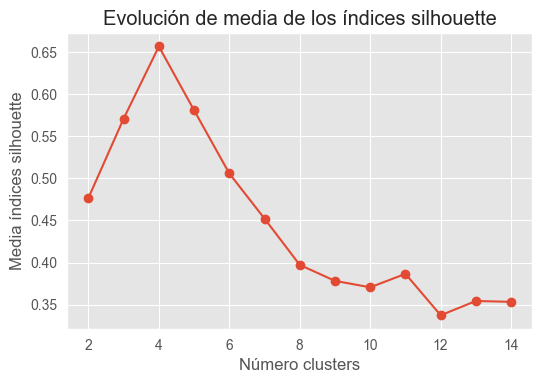

In [10]:
# M√©todo silhouette para identificar el n√∫mero √≥ptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evoluci√≥n de media de los √≠ndices silhouette")
ax.set_xlabel('N√∫mero clusters')
ax.set_ylabel('Media √≠ndices silhouette');

En este ejemplo se utiliza el an√°lisis de silhouette para elegir un valor √≥ptimo para n_clusters. El gr√°fico de silhouette muestra que los valores n_clusters de 3, 5 y 6 son una mala elecci√≥n para los datos dados.

# Cluster jer√°rquico

Usaremos el dataset USArrests que contiene estad√≠sticas sobre arrestos por cada 100,000 residentes por asalto, asesinato y violaci√≥n en cada uno de los 50 estados de EE. UU. en 1973. Tambi√©n se da el porcentaje de la poblaci√≥n que vive en √°reas urbanas.

In [15]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

# Gr√°ficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuraci√≥n warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Datos

In [16]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
USArrests['StateAbbrv'] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT","DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ","NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC","SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

datos = USArrests.data
datos.head(4)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

Los escalamos

In [ ]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(X=datos, axis=0, with_mean=True, with_std=True)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos.columns, index=datos.index)
datos_scaled.head(4)

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta funci√≥n extrae la informaci√≥n de un modelo AgglomerativeClustering
    y representa su dendograma con la funci√≥n dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Los par√°metros de la clase `sklearn.cluster.AgglomerativeClustering` que destacan:

- `n_clusters`: determina el n√∫mero de clusters que se van a generar. En su lugar, su valor puede ser None si se quiere utilizar el criterio `distance_threshold` para crear los clusters o crecer todo el dendograma.
- `distance_threshold`: distancia (altura del dendograma) a partir de la cual se dejan de unir los clusters. Indicar `distance_threshold=0` para crecer todo el √°rbol.
- `compute_full_tree`: si se calcula la jerarqu√≠a completa de clusters. Debe ser `True` si `distance_threshold` es distinto de `None`.
- `affinity`: m√©trica utilizada como distancia. Puede ser: ‚Äúeuclidean‚Äù, ‚Äúl1‚Äù, ‚Äúl2‚Äù, ‚Äúmanhattan‚Äù, ‚Äúcosine‚Äù, or ‚Äúprecomputed‚Äù. Si se utiliza `linkage=‚Äúward‚Äù`, solo se permite ‚Äúeuclidean‚Äù.
- `linkage: tipo de linkage utilizado. Puede ser ‚Äúward‚Äù, ‚Äúcomplete‚Äù, ‚Äúaverage‚Äù o ‚Äúsingle‚Äù.

Al aplicar un hierarchical clustering aglomerativo se tiene que escoger una medida de distancia y un tipo de linkage. El concepto de linkage contempla la forma que tenemos de medir la distancia entre pares de grupos. Tenemos varias formas:
- `"ward"`. La elecci√≥n de los pares de clusters que se fusionan en cada etapa del *agglomerative hierarchical clustering* se fundamenta en el valor √≥ptimo de una funci√≥n objetivo, la cual puede ser cualquier funci√≥n determinada por el analista. El m√©todo de *Ward's minimum variance* es un ejemplo espec√≠fico en el cual el prop√≥sito es reducir al m√≠nimo la suma total de la varianza intra-cluster. Durante cada fase, se identifican aquellos 2 clusters cuya fusi√≥n resulta en el menor aumento de la varianza total intra-cluster. Este indicador es an√°logo a la m√©trica que se busca minimizar en el algoritmo K-means.
- `"complete"`. Se calcula la distancia entre todos los posibles pares formados por una observaci√≥n del cluster A y una del cluster B. La mayor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida m√°s conservadora
- `"average"`. Se calcula la distancia entre todos los posibles pares formados por una observaci√≥n del cluster A y una del cluster B. El valor promedio de todas ellas se selecciona como la distancia entre los dos clusters.
- `"single"`.Se calcula la distancia entre todos los posibles pares formados por una observaci√≥n del cluster A y una del cluster B. La menor de todas ellas se selecciona como la distancia entre los dos clusters. Se trata de la medida menos conservadora

A continuaci√≥n, se comparan los resultados con los linkages complete, ward y average, utilizando la distancia eucl√≠dea como m√©trica de similitud.

In [ ]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=datos_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=datos_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=datos_scaled)

In [ ]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=datos_scaled.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia eucl√≠dea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=datos_scaled.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia eucl√≠dea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia eucl√≠dea, Linkage ward")
plt.tight_layout();

## N√∫mero de clusters
Una forma de decidir el n√∫mero de clusters, puede ser inspeccionando el dendograma y elegir la altura a la que se corta para generar los clusters. Por ejemplo, para los resultados de distancia euclidea y linkage ward, parece que una buena altura ser√≠a 5 y tendr√≠amos 4 clusters

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
plot_dendrogram(modelo_hclust_ward, labels=datos_scaled.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia eucl√≠dea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Otra forma de identificar potenciales valores √≥ptimos para el n√∫mero de clusters en modelos hierarchical clustering es mediante los √≠ndices silhouette.

In [ ]:
# M√©todo silhouette para identificar el n√∫mero √≥ptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        metric   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evoluci√≥n de media de los √≠ndices silhouette")
ax.set_xlabel('N√∫mero clusters')
ax.set_ylabel('Media √≠ndices silhouette');

In [ ]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 4
)
modelo_hclust_ward.fit(X=X_scaled)

Otra manera de elegir el n√∫mero de clusters consiste en determinar la situaci√≥n donde se produce un salto grande entre alturas. Si se produce un salto grande quiere decir que hace falta una distancia demasiado grande para fusionar los clusters. Por tanto, puede ser preferible parar de fusionar clusters antes de esa altura.

In [ ]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calculamos la matriz de enlace con linkage 'complete'
Z = sch.linkage(datos_scaled, method='complete')

# Extraemos las alturas de fusi√≥n
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusi√≥n

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# √çndice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# N√∫mero √≥ptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump

# Altura de fusi√≥n en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"N√∫mero √≥ptimo de clusters: {n_clusters_optimo}")
print(f"Altura de fusi√≥n √≥ptima: {altura_optima:.2f}")

# Ahora ploteamos la informaci√≥n

# Graficamos la altura de fusi√≥n y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gr√°fico de las alturas de fusi√≥n
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("√çndice de Fusi√≥n")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gr√°fico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("√çndice de Fusi√≥n")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura √≥ptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura √≥ptima de corte")
plt.xlabel("√çndice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

# DBSCAN: Density-based spatial clustering of applications with noise


In [18]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gr√°ficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuraci√≥n warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [19]:
datos = pd.read_csv('DBSCAN.csv')
datos.head()

x         y  shape
0 -0.803739 -0.853053      1
1  0.852851  0.367618      1
2  0.927180 -0.274902      1
3 -0.752626 -0.511565      1
4  0.706846  0.810679      1

Con la clase `sklearn.cluster.DBSCAN` de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo DBSCAN. Entre sus par√°metros destacan:
- `eps`: Distancia m√°xima entre dos muestras para que una se considere vecina de la otra. Define el *ùúñ-neighborhood*
- `min_samples`: El n√∫mero de muestras (o peso total) en un vecindario para que un punto se considere un *core point*. Esto incluye el propio punto. Si `min_samples` se establece en un valor m√°s alto, DBSCAN encontrar√° conglomerados m√°s densos, mientras que si se establece en un valor m√°s bajo, los conglomerados encontrados ser√°n m√°s dispersos.
- metric: m√©trica utilizada como distancia. Puede ser: ‚Äúeuclidean‚Äù, ‚Äúl1‚Äù, ‚Äúl2‚Äù, ‚Äúmanhattan‚Äù, ‚Äúcosine‚Äù, or ‚Äúprecomputed‚Äù. Por defecto es ‚Äúeuclidean‚Äù.

In [20]:
from sklearn.preprocessing import StandardScaler

# Escalado de datos
# ==============================================================================
X = datos.drop(columns='shape').to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


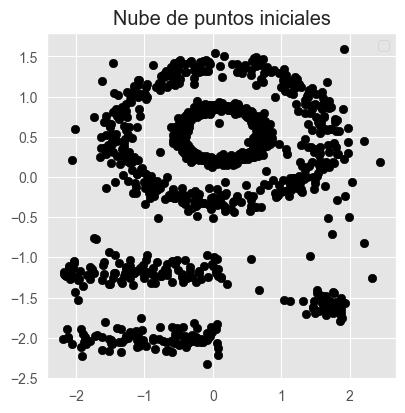

In [21]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

In [23]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

DBSCAN(eps=0.2)

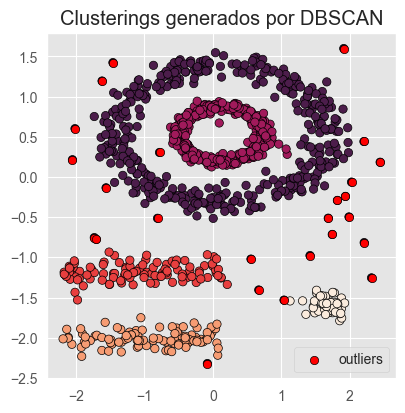

In [24]:
# Clasificaci√≥n
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [25]:
# N√∫mero de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'N√∫mero de clusters encontrados: {n_clusters}')
print(f'N√∫mero de outliers encontrados: {n_noise}')

N√∫mero de clusters encontrados: 5
N√∫mero de outliers encontrados: 25


Vamos a determinar una eps adecuada

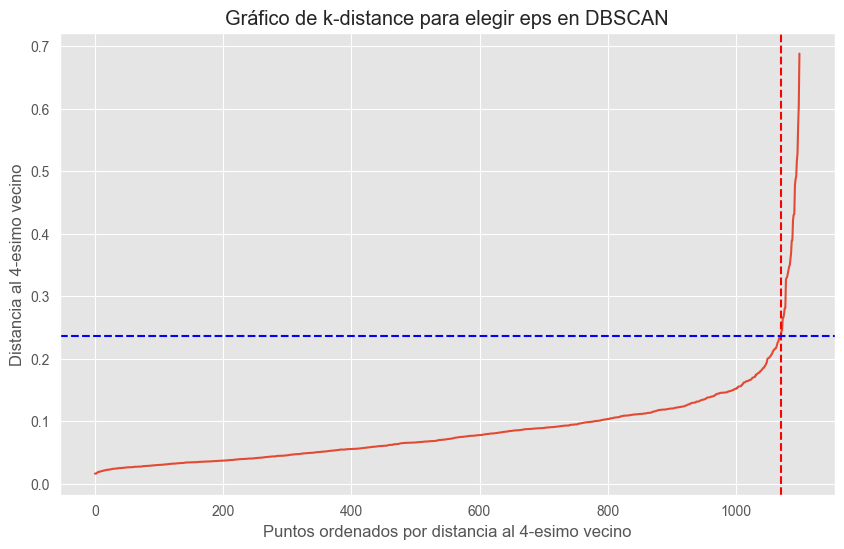

x_point=1070 y_value=0.23667785377389358


In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 1070
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gr√°fico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la l√≠nea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Vemos que una eps de aproximadamente eps=0.24 corresponde al codo en el gr√°fico anterior (no muy distinta de eps=0.2) que ya hab√≠amos probado). Probemos entonces con eps=0.24

In [17]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = y_value,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

# Clasificaci√≥n
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# N√∫mero de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'N√∫mero de clusters encontrados: {n_clusters}')
print(f'N√∫mero de outliers encontrados: {n_noise}')





NameError: name 'DBSCAN' is not defined